In [1]:
# We need to first download the data here:
file_id = '1-mQuJbHvSq9nRugy96dr0aB7isfzaxMZ'
file_download_link = "https://docs.google.com/uc?export=download&id=" + file_id
#!wget -O data.zip --no-check-certificate "$file_download_link"
#!unzip data.zip


#### Dense Layer Class
- structure to hold an arbitrary number of nodes
- will have various activation functions
- will perform the forward pass through the single layer (z and A)
- will perform the backward pass for the layer
- will perform the update step for the layer

#### Neural Network Class
- structure to hold an arbitrary number of layers
- will perform the forward pass sequentially through all layers
- will do the cost calculation for various loss functions
- will perform the backward pass and calculate all gradients
- will do an update (a step of gradient descent)


## Step by step implementation of our ANN class

Now lets start to implement our NN classes. First import numpy

In [2]:
import numpy as np

Before we can define our main NN class, we need to define our Dense layer class. As I want to do some error checking, we will first define some custom Exceptions:

In [3]:
class ActivationDoesNotExist(Exception):
    """Valid activations are sigmoid, tanh, and relu, provided as a string"""
    pass

class InputDimensionNotCorrect(Exception):
    """Need to specify input dimension, i.e. input shape into the first layer"""
    pass

class LossFunctionNotDefined(Exception):
    """Loss function in cost() method not defined"""
    pass

Now we can begin with our new class called DenseLayer. This class takes an constructor with two required parameters:
- inputDimension, i.e. the number of features of the input vector, or the number of units from the previous layer
- units, i.e. the number of neurons in this layer
There are two more optional parameters:
- activation: here you can indicate what activation the layer should use. Defined are sigmoid, relu, tanh, and ''. The empty string indicates no activation, meaning we just have a regression.
- randomMultiplier is the value which the random weights are multiplied. Generally 0.01 is fine, but sometimes tweaking this number can help.

As there can me different activation functions and we do not want to chech which activation we have using an if-statement, we make a reference to the used activation functions in the init statement.

In the initialize method, the weights are initialized. Notice that the number of neurons nh (units) are in the rows, and the number of input features nx are the columns. This is required to make our dot product work later.

Another thing I learned recently is the use of 'self' in Python. While I though I understood the concept, I did not fully understand the concequences. The definition of the class is separated from the values of each instance. These values are stored in the self object, i.e. the object of the instance. In other programming languages it is common to define types it the class itself. However, in Python you have to define these in the init method. When not doing this, the variable is the same object in all your instances and you can get weird results. I just found this [blog-post](https://towardsdatascience.com/python-pitfall-mutable-default-arguments-9385e8265422) where Don Cross has a very clear explanation.


```python
class DenseLayer:
    def __init__(self, inputDimension, units, activation='', randomMultiplier=0.01):
        self.weights, self.bias = self.initialize(inputDimension, units, randomMultiplier)
        if activation == 'sigmoid':
            self.activation = activation
            self.activationForward = self.sigmoid
            self.activationBackward = self.sigmoidGrad
        elif activation == 'relu':
            self.activation = activation
            self.activationForward = self.relu
            self.activationBackward = self.reluGrad
        elif activation == 'tanh':
            self.activation = activation
            self.activationFunction = self.tanh
            self.activationBackward = self.tanhGrad
        elif activation != '':
            raise ActivationDoesNotExist
        else:
            self.activation = 'none'
            self.activationFunction = self.linear
            self.activationBackward = self.linear
    
    def initialize(self, nx, nh, randomMultiplier):
        weights = randomMultiplier * np.random.randn(nh, nx)
        bias = np.zeros([nh, 1])
        return weights, bias

```

Next we define all used activation functions. The sigmoid we already know from the previous Tutorial, however we also include tanh and relu, which are also very common activation functions.

Tanh or hyperbolic tangent in full is a function which is similar to the sigmoid, however it maps all real values between -1 and +1. It was very popular, before the Relu function made its way to the stage. 

Relu, which stands for Rectified linear unit, is probably the most popular activation function. It is fast to calculate and has often better results than the Tanh function. Therefore, if you are not sure, the Relu function is a great start. The Relu function maps all values smaller than 0 to zero and all values larger than 0 as the value itself. 

The last activation function we will introduce is called the linear function. This is the same as not having an activation function, and is just a placeholder. What comes in, comes out and we use it to test our previous excersise on Linear regression.

The backward pass needs the differentials of all these functions, which are provided with the Grad suffix. Feel free to check if these differentials are correct. One additional step for each Grad calculation is that we multiply the input gradient (dA0 with the calculated gradient. This is required because we use the [chain rule](https://en.wikipedia.org/wiki/Differentiation_rules#The_chain_rule) (continously through back propagation).


```python
    def sigmoid(self, Z):
            A = 1 / (1 + np.exp(-Z))
            return A
        
    def sigmoidGrad(self, dA):
            s = 1 / (1 + np.exp(-self.prevZ))
            dZ = dA * s * (1 - s)
            return dZ
    
    
    def relu(self, Z):
            A = np.maximum(0, Z)
            return A
        
    def reluGrad(self, dA):
            s = np.maximum(0, self.prevZ)
            dZ = (s>0) * 1 * dA
            return dZ 

        
    def tanh(self, Z):
            A = np.tanh(Z)
            return A

    def tanhGrad(self, dA):
            s = np.tanh(self.prevZ)
            dZ = (1 - s**2) * dA
            return dZ


    def linear(self, Z):
        return Z
```

Next, we define the forward propagation step, which should look very familiar:
```python
    def forward(self, A):
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        return A
```

Here, we first calculate the linear part. Store the values for Z and A for later use in the back propagation and next apply the activation function.


Before starting our backpropstep we need to define our loss function. For logistic regression it's done with the binary cross entropy, for which I will simply give the equation. 
\begin{equation}
loss = -\frac{1}{m}\sum_{i=1}^{m}y\log(A)+(1-y)\log(1-A)
\end{equation}

Now for the backwards pass, We would need to differentiate the Loss function with $W$ and $b$. Not to  bore you guys, 
I have provided these functions:

\begin{equation}
 \frac{\partial loss}{\partial W} = \frac{1}{m} \sum_{i=1}^m  X(A - Y)^T \\
 \frac{\partial loss}{\partial b} = \frac{1}{m} \sum_{i=1}^m (A - y)
\end{equation}

In Python, this looks like this:

The backward propagation looks again similar to the previous tutorial, however we have split the backward activation part to the activation functions itself. Also this function expects to get dA, which is a more generalized form for multiple layers. In our previous single layer example we combined the differential of the loss function in this step. Now this step is in our NN class and not in each layer, as it is only required at the last layer.

```python
  def backward(self, dA):
        dZ = self.activationBackward(dA)
        m = self.prevA.shape[1]
        self.dW = 1 / m * np.dot(dZ, self.prevA.T)
        self.db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(self.weights.T, dZ)
        return prevdA 
```

The gradients are stored in the layer and can be used later by the update function, which performs the gradient descent step. This backward passes chain together for each layer as we will see later.


The final required function is the update function, which performs the gradient descent step. Nothing spectacular but it expects a learning rate.

```python
    def update(self, learning_rate):
        self.weights = self.weights - learning_rate * self.dW
        self.bias = self.bias - learning_rate * self.db
```


While not required, these next function help in printing the model

```python    
    def __repr__(self):
        act = 'none' if self.activation == '' else self.activation
        return f'Dense layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
```


### The complete DenseLayer class

In [4]:
class DenseLayer:
    """
    A class to define fully connected layers.
    """
    
    def __init__(self, inputDimension, units, activation='', randomMultiplier=0.01):
        """
        Constructor:
          inputDimension: number of input features
          units: number of neurons in the layer
          activation: activation function applied to layer
            - options: 'sigmoid', 'tanh', 'relu', ''
          randomMultiplier: multiplier applied to the random weights during initialization
        """
        self.weights, self.bias = self.initialize(inputDimension, units, randomMultiplier)
        if activation == 'sigmoid':
            self.activation = activation
            self.activationForward = self.sigmoid
            self.activationBackward = self.sigmoidGrad
        elif activation == 'relu':
            self.activation = activation
            self.activationForward = self.relu
            self.activationBackward = self.reluGrad
        elif activation == 'tanh':
            self.activation = activation
            self.activationForward = self.tanh
            self.activationBackward = self.tanhGrad
        elif activation != '':
            raise ActivationDoesNotExist
        else:
            self.activation = 'none'
            self.activationForward = self.linear
            self.activationBackward = self.linear
    
    def initialize(self, nx, nh, randomMultiplier):
        """
        Initializes weights randomly:
          nx: number of input features
          nh: number of units
          randomMultiplier: multiplier applied to the random weights during initialization
        returns:
          weights: the randomly initialized weights
          bias: the bias terms
        """
        weights = randomMultiplier * np.random.randn(nh, nx)
        bias = np.zeros([nh, 1])
        return weights, bias

    
    def sigmoid(self, Z):
        """
        Sigmoid activation function
        """
        A = 1 / (1 + np.exp(-Z))
        return A
        
    def sigmoidGrad(self, dA):
        """
        Differential of sigmoid function with chain rule applied
        """
        s = 1 / (1 + np.exp(-self.prevZ))
        dZ = dA * s * (1 - s)
        return dZ
    
    
    def relu(self, Z):
        """
        Relu activation function
        """
        A = np.maximum(0, Z)
        return A
        
    def reluGrad(self, dA):
        """
        Differential of relu function with chain rule applied
        """
        s = np.maximum(0, self.prevZ)
        dZ = (s>0) * 1 * dA
        return dZ 

        
    def tanh(self, Z):
        """
        Tanh activation function
        """
        A = np.tanh(Z)
        return A

    def tanhGrad(self, dA):
        """
        Differential of tanh function with chain rule applied
        """
        s = np.tanh(self.prevZ)
        dZ = (1 - s**2) * dA
        return dZ


    def linear(self, Z):
        """
        Placeholder when no activation function is used
        """
        return Z
        
    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        return A
    
    
    def backward(self, dA):
        """
        Backward pass through layer
          dA: previous gradient
        """
        dZ = self.activationBackward(dA)
        m = self.prevA.shape[1]
        self.dW = 1 / m * np.dot(dZ, self.prevA.T)
        self.db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(self.weights.T, dZ)
        return prevdA
    
    
    def update(self, learning_rate):
        """
        Update weights using gradients from backward pass
          learning_rate: the learning rate used in the gradient descent
        """
        self.weights = self.weights - learning_rate * self.dW
        self.bias = self.bias - learning_rate * self.db

        
    def outputDimension(self):
        """
        Returns the output dimension for the next layer
        """
        return len(self.bias)

    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dense layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'



### Alright, one down and one to go.
Next we will create a class that will combine the layers. It will also hold the loss function and has to calculate the gradient of the loss. For convenience, we will also add a wrapper to add layers and add a way to pretty print our model.

First we start again with the constructor, which has two options, the loss function to be used, and the randomMultiplier used for new layers. The loss function are again created in a function reference and are called using wrapper functions.

The model starts with no layers (empty).

```python
class NeuralNetwork:
    def __init__(self, loss='cross-entropy', randomMultiplier = 0.01):
        self.layers=[]
        self.randomMultiplier = randomMultiplier
        if loss=='cross-entropy':
            self.lossFunction = self.crossEntropyLoss
            self.lossBackward = self.crossEntropyLossGrad
        elif loss=='mean-square-error':
            self.lossFunction = self.meanSquareError
            self.lossBackward = self.meanSquareErrorGrad
        else:
            raise LossFunctionNotDefined
        self.loss=loss
```


The next function is a helper function to add layers to the model. You need to give the inputDimension, i.e. the number of input features of the first layer. For the second and further, it will look for the previous layer and use that as the input dimension.

You have to specify the number of neurons in the layer (units) and which activation function to use.

```python
    def addLayer(self, inputDimension=None, units=1, activation=''):
        if (inputDimension is None):
            if (len(self.layers)==0):
                raise InputDimensionNotCorrect
            inputDimension=self.layers[-1].outputDimension()
        layer = DenseLayer(inputDimension, units, activation, randomMultiplier= self.randomMultiplier)
        self.layers.append(layer)
```

Next we define the loss functions and their differentials. Feel free to check if the differentials are correct. the cost method is a wrapper to cal the cost in the training loop later.

```python
    def crossEntropyLoss(self, Y, A, epsilon=1e-15):
        m = Y.shape[1]
        loss = -1 * (Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
            
    def crossEntropyLossGrad(self, Y, A):
        dA = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        return dA
    
    
    def meanSquareError(self, Y, A):
        loss = np.square(Y - A)
        m = Y.shape[1]
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
    
    def meanSquareErrorGrad(self, Y, A):
        dA = -2 * (Y - A)
        return dA

    
    def cost(self, Y, A):
        return self.lossFunction(Y, A)
```

The forward, backward, and update method are quite similar as they loop over the layers:

```python
    def forward(self, X):
        x = np.copy(X)
        for layer in self.layers:
            x = layer.forward(x)
        return x
            
    
    def backward(self, A, Y):
        dA = self.lossBackward(Y, A)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
    
    
    def update(self, learning_rate=0.01):
        for layer in self.layers:
            layer.update(learning_rate)
```

the backward pass first hast to calculate the first dA, which is de gradient between the activation and the real values. This is then looped through the layers to calculate all gradients.


The last two methods are again for pretty printing and one for trainable parameter counting. Nothing special.

### The complete NeuralNetwork class

In [5]:
class NeuralNetwork:
    """
    Neural Network structure that holds our layers
    """
    
    def __init__(self, loss='cross-entropy', randomMultiplier = 0.01):
        """
        Constructor:
          loss: the loss function. Two are defined:
             - 'cross-entropy' and 'mean-square-error'
          randomMultiplier: multiplier applied to the random weights during initialization
        """
        self.layers=[]
        self.randomMultiplier = randomMultiplier
        if loss=='cross-entropy':
            self.lossFunction = self.crossEntropyLoss
            self.lossBackward = self.crossEntropyLossGrad
        elif loss=='mean-square-error':
            self.lossFunction = self.meanSquareError
            self.lossBackward = self.meanSquareErrorGrad
        else:
            raise LossFunctionNotDefined
        self.loss=loss


    def addLayer(self, inputDimension=None, units=1, activation=''):
        """
        Adds a Dense layer to the network:
          inputDimension: required when it is the first layer. otherwise takes dimensions of previous layer.
          units: number of neurons in the layer
          activation: activation function: valid choices are: 'sigmoid', 'tanh', 'relu', ''
        """
        if (inputDimension is None):
            if (len(self.layers)==0):
                raise InputDimensionNotCorrect
            inputDimension=self.layers[-1].outputDimension()
        layer = DenseLayer(inputDimension, units, activation, randomMultiplier= self.randomMultiplier)
        self.layers.append(layer)

    def crossEntropyLoss(self, Y, A, epsilon=1e-15):
        """
        Cross Entropy loss function
          Y: true labels
          A: final activation function (predicted labels)
          epsilon: small value to make minimize chance for log(0) error
        """
        m = Y.shape[1]
        loss = -1 * (Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
            
    def crossEntropyLossGrad(self, Y, A):
        """
        Cross Entropy loss Gradient
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        return dA
    
    
    def meanSquareError(self, Y, A):
        """
        Mean square error loss function
          Y: true labels
          A: final activation function (predicted labels)
        """
        loss = np.square(Y - A)
        m = Y.shape[1]
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
    
    def meanSquareErrorGrad(self, Y, A):
        """
        Mean square error loss gradient
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = -2 * (Y - A)
        return dA

    
    def cost(self, Y, A):
        """
        Cost function wrapper
          Y: true labels
          A: final activation function (predicted labels)
        """
        return self.lossFunction(Y, A)

        
    def forward(self, X):
        """
        Forward pass through the whole model.
          X: input vector
        """
        x = np.copy(X)
        for layer in self.layers:
            x = layer.forward(x)
        return x
            
    
    def backward(self, A, Y):
        """
        backward pass through the whole model
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = self.lossBackward(Y, A)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
    
    
    def update(self, learning_rate=0.01):
        """
        Update weights and do a step of gradient descent for the whole model.
          learning_rate: learning_rate to use
        """
        for layer in self.layers:
            layer.update(learning_rate)
    
    
    def __repr__(self):
        """
        Pretty print the model
        """
        layrepr = ['  ' + str(ix+1)+' -> ' + str(x) for ix, x in enumerate(self.layers)]
        return '[\n' + '\n'.join(layrepr) + '\n]'
   
    
    def numberOfParameters(self):
        """
        Print number of trainable parameters in the model
        """
        n = 0
        for layer in self.layers:
            n += np.size(layer.weights) + len(layer.bias)
        print(f'There are {n} trainable parameters in the model.')
            

Alright, the classes are done. Now we need to put these classes to a test. While it looks quite ordered, a small error in one of the differentials can make our whole system useless. Therefore, we will test in small steps in the next section. Looking forward for the spin!

### Linear regression

We created an array with a couple of input values $X$. Next we supplied $Y$ using the super duper complicated formula $y = 2x + 1$. In Numpy this looks like this:

In [6]:
import numpy as np

In [7]:
X = np.arange(-2, 5, 1).reshape([1, 7]) # Columns as examples
Y = 2 * X + 1

Now we will build our model which will try to find our difficult formula and match the true value of 25. For this we will initiate our fresh class and set the loss to mean-square-error. Next we will add a single layer, with a single neuron and no activation function. Lets also try our pretty print :-)

In [8]:
np.random.seed(1)

model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=1, units=1, activation='')
model

[
  1 -> Dense layer (nx=1, nh=1, activation=none)
]

Now we will need our training loop again. It will look very familiar to our logistic regression model from last time:

In [9]:
num_iterations = 1000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, Y)
    model.update()
    if ix % 100 == 0:
        print('cost:', model.cost(Y, A)) 

cost: 24.643963268924306
cost: 0.009408179907957642
cost: 0.00043269013393172113
cost: 1.989979716251954e-05
cost: 9.152090515935006e-07
cost: 4.2091263608210285e-08
cost: 1.935813975001762e-09
cost: 8.902977540761639e-11
cost: 4.094557128292547e-12
cost: 1.8831225851087109e-13


The cost decreases as expected and due to the long training the value is close to machine precision. Would we again find 25 when we use the forward?

In [10]:
model.forward(12)

array([[25.00000019]])

Of course we do!

### A go at our Titanic dataset

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('./data/titanic/train_data.csv')
df = df.drop(['Unnamed: 0', 'PassengerId'], axis=1)
Y = df['Survived'].to_numpy().reshape([1, -1])
X = df.iloc[:,1:].to_numpy().T

In [13]:
X.shape

(14, 792)

In [14]:
Y.shape

(1, 792)

We need to change the model to have 14 input features and of course the sigmoid activation function. The loss function will be cross-entropy, which is the default, so we do not need to specify it.

In [15]:
np.random.seed(1)

model = NeuralNetwork()
model.addLayer(inputDimension=14, units=1, activation='sigmoid')
model

[
  1 -> Dense layer (nx=14, nh=1, activation=sigmoid)
]

Last time, we had an train accuracy of 80%. Can we match this as well?

In [16]:
def roundValue(A):
    return np.uint8( A > 0.5)

def accuracy(yhat, Y):
    return round(np.sum(yhat==Y) / len(yhat.flatten()) * 1000) / 10

In [17]:
num_iterations = 8000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, Y)
    model.update()
    if ix % 1000 == 0:
        yhat = roundValue(A)
        print('cost:', model.cost(Y, A), f'\taccuracy: {accuracy(yhat, Y)}%')     

cost: 0.6912384614194468 	accuracy: 58.7%
cost: 0.5140056920509907 	accuracy: 75.9%
cost: 0.4824062497934128 	accuracy: 79.5%
cost: 0.4697113881273363 	accuracy: 79.5%
cost: 0.46275860969195476 	accuracy: 79.8%
cost: 0.4580742945870081 	accuracy: 79.8%
cost: 0.4544915367177524 	accuracy: 79.8%
cost: 0.4515471545581365 	accuracy: 80.8%


Of course we can!

In [18]:
# Prerequisite library imports
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/titanic/train_data.csv')
X = df.drop(['Unnamed: 0', 'PassengerId'], axis=1)
y = df['Survived']
X = X.drop(columns = 'Survived')

In [19]:
import seaborn as sns
#sns.pairplot(X)

In [20]:
# Please use your scalarization of X here: then run the cell below to split your training and test data
import pandas as pd 

df = pd.read_csv("./data/titanic/train_data.csv")

normalized_df=(df-df.min())/(df.max()-df.min())

X = normalized_df.drop(['Unnamed: 0', 'PassengerId'], axis = 1)
y = normalized_df['Survived']
X = normalized_df.drop(columns = 'Survived')

In [21]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
display(X_train.shape)
display(y_train.shape)

(633, 16)

(633,)

I predicted that there would be a possible negative value here. Thus I used min max normalisation. 

```python
MYACTIVATIONFXN = 'SOMEFXN'
model.add(Dense(units = 14, activation = MYACTIVATIONFXN, input_dim = ?))
```


In [53]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.model_selection import train_test_split 
import pandas as pd 

df = pd.read_csv("data/titanic/train_data.csv")

normalized_df=(df-df.min())/(df.max()-df.min())

X = normalized_df.drop(['Unnamed: 0', 'PassengerId'], axis = 1)
y = normalized_df['Survived']
X = normalized_df.drop(columns = 'Survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

model = Sequential()

MYACTIVATIONFXN = 'relu'
model.add(Dense(units = 16, activation = MYACTIVATIONFXN, input_dim = X_train.shape[1]))
model.add(Dense(units = 1, activation = MYACTIVATIONFXN, input_dim = X_train.shape[1]))

In [23]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

### Here we will run our ANN using the fit function using a batch size of 1 and 10 epochs

In [24]:
model.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 10)

Epoch 1/10
633/633 [==============================] - 1s 1ms/step - loss: 5.1413
Epoch 2/10
633/633 [==============================] - 1s 1ms/step - loss: 2.9486
Epoch 3/10
633/633 [==============================] - 1s 1ms/step - loss: 1.7081
Epoch 4/10
633/633 [==============================] - 1s 1ms/step - loss: 1.5057
Epoch 5/10
633/633 [==============================] - 1s 1ms/step - loss: 1.5422
Epoch 6/10
633/633 [==============================] - 1s 2ms/step - loss: 1.5927
Epoch 7/10
633/633 [==============================] - 1s 1ms/step - loss: 1.6044
Epoch 8/10
633/633 [==============================] - 1s 1ms/step - loss: 1.8324
Epoch 9/10
633/633 [==============================] - 1s 1ms/step - loss: 1.7176
Epoch 10/10
633/633 [==============================] - 1s 1ms/step - loss: 1.8075


In [25]:
yhat_test = model.predict(X_test)
yhat_test = [ 1 if y>=0.5 else 0 for y in yhat_test ]

5/5 [==============================] - 0s 2ms/step


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
myconfusionmatrix = confusion_matrix(y_test, yhat_test)
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81        92
         1.0       0.79      0.57      0.66        67

    accuracy                           0.75       159
   macro avg       0.77      0.73      0.73       159
weighted avg       0.76      0.75      0.75       159



The precision and recall values for the two combine out to be the aggregate for our model. That returns the accuracy for our model. This is in the late 70s based on the runs. This run that it is written after gave an accuracy of 77 percent. This is less than the 80 percent accuracy of the example which is probably due to the fine tuned nature of the example which is specific to this dataset whereas the model I have will run on any dataset. Due to the general nature, we lose the accuracy aspect of the result. 

## 2) Complex fit of flowers

First we need to import the data:

In [27]:
import numpy as np
data = np.load('./data/rose/rose.npz')
X, Y = data['X'], data['Y']

To give a feel how it looks, we will first plot the rose, which has 7 petals:

In [28]:
import matplotlib.pyplot as plt

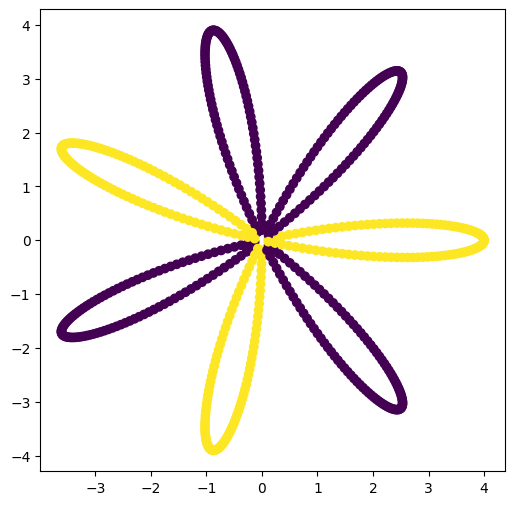

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(X[0,:], X[1,:], c=Y.flatten())

We discussed before that a logistic regression model, like we have defined in our previous example, can only divide in a line. Lets try this out, as the data is clearly not defined in a line.

In [30]:
np.random.seed(1)

model = NeuralNetwork()
model.addLayer(inputDimension=2, units=1, activation='sigmoid')
model

[
  1 -> Dense layer (nx=2, nh=1, activation=sigmoid)
]

In [31]:
num_iterations = 1000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, Y)
    model.update(learning_rate=1.2)
    if ix % 1000 == 0:
        print('cost:', model.cost(Y, A)) 

cost: 0.6927732264810165


A short piece of code to generate a contour plot and our Rose

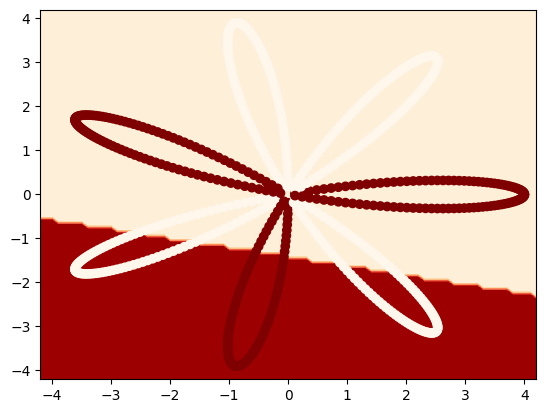

In [32]:
def testModel(X, Y, h=0.1, f=1.05):
    r = X.max()
    xmesh, ymesh = np.meshgrid(np.arange(-r*f, r*f+h, h), np.arange(-r*f, r*f+h, h))
    Z = model.forward(((np.c_[xmesh.ravel(), ymesh.ravel()]).T))
    Z = (Z > 0.5) * 1
    Z = Z.T.reshape(xmesh.shape)
    plt.contourf(xmesh, ymesh, Z, cmap=plt.cm.OrRd)
    plt.scatter(X[0, :], X[1, :], c=Y.flatten(), cmap=plt.cm.OrRd)
testModel(X, Y)

Definitely not a great fit and clearly a line. Now lets add another layer with four units to the model, with the last layer being the same sigmoid layer. The activation function for this model we keep similar to the one from Andrew, which was a tanh.

In [33]:
np.random.seed(1)

model = NeuralNetwork()
model.addLayer(inputDimension=2, units=4, activation='tanh')
model.addLayer(units=1, activation='sigmoid')
model

[
  1 -> Dense layer (nx=2, nh=4, activation=tanh)
  2 -> Dense layer (nx=4, nh=1, activation=sigmoid)
]

In [34]:
num_iterations = 4000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, Y)
    model.update(learning_rate=1.2)
    if ix % 1000 == 0:
        print('cost:', model.cost(Y, A)) 

cost: 0.6931058695708833
cost: 0.01872511046013703
cost: 0.010960375476196646
cost: 0.007723264407820055


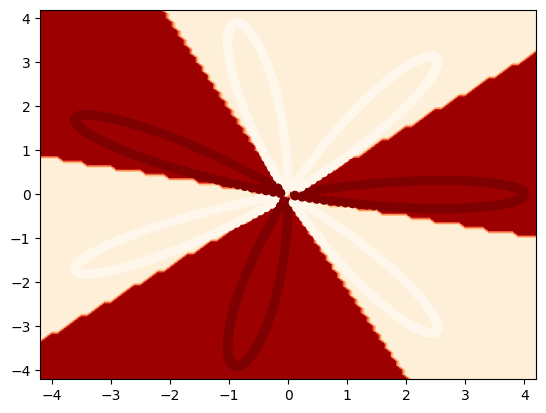

In [35]:
testModel(X,Y)

This is something that really amazes me. Just a tiny layer more and we have the power to learn this much more complex function. Really great stuff!

In [36]:
import numpy as np
data = np.load('./data/rose/rose.npz')
X, y = data['X'].transpose(), data['Y'].transpose()
display(X.shape)
display(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
display(X_train.shape)
display(y_train.shape)

# Let's initialize our model
tanh = Sequential() # Initialising the ANN for tanh
relu = Sequential() # Initialising the ANN for relu
sigmoid = Sequential() # Initialising the ANN for sigmoid

(688, 2)

(688, 1)

(550, 2)

(550, 1)

In [37]:
tanh.add(Dense(units = 1, activation = 'tanh', input_dim = X_train.shape[1]))
tanh.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
tanh.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 10)

Epoch 1/10
550/550 [==============================] - 1s 1ms/step - loss: 2.6334
Epoch 2/10
550/550 [==============================] - 1s 1ms/step - loss: 2.4344
Epoch 3/10
550/550 [==============================] - 1s 1ms/step - loss: 2.3726
Epoch 4/10
550/550 [==============================] - 1s 1ms/step - loss: 2.3069
Epoch 5/10
550/550 [==============================] - 1s 990us/step - loss: 2.2812
Epoch 6/10
550/550 [==============================] - 1s 979us/step - loss: 2.2641
Epoch 7/10
550/550 [==============================] - 1s 1ms/step - loss: 2.1932
Epoch 8/10
550/550 [==============================] - 1s 980us/step - loss: 2.2347
Epoch 9/10
550/550 [==============================] - 1s 1ms/step - loss: 2.1767
Epoch 10/10
550/550 [==============================] - 1s 1ms/step - loss: 2.1690


In [38]:
relu.add(Dense(units = 1, activation = 'relu', input_dim = X_train.shape[1]))
relu.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
relu.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 10)

Epoch 1/10
550/550 [==============================] - 1s 1ms/step - loss: 6.7400
Epoch 2/10
550/550 [==============================] - 1s 1ms/step - loss: 6.0019
Epoch 3/10
550/550 [==============================] - 1s 1ms/step - loss: 4.9882
Epoch 4/10
550/550 [==============================] - 1s 1ms/step - loss: 4.1257
Epoch 5/10
550/550 [==============================] - 1s 1ms/step - loss: 4.0601
Epoch 6/10
550/550 [==============================] - 1s 1ms/step - loss: 4.0730
Epoch 7/10
550/550 [==============================] - 1s 1ms/step - loss: 4.0676
Epoch 8/10
550/550 [==============================] - 1s 1ms/step - loss: 4.0865
Epoch 9/10
550/550 [==============================] - 1s 1ms/step - loss: 4.1093
Epoch 10/10
550/550 [==============================] - 1s 1ms/step - loss: 4.1108


In [39]:
sigmoid.add(Dense(units = 1, activation = 'sigmoid', input_dim = X_train.shape[1]))
sigmoid.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
sigmoid.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 10)

Epoch 1/10
550/550 [==============================] - 1s 1ms/step - loss: 0.9007
Epoch 2/10
550/550 [==============================] - 1s 2ms/step - loss: 0.7862
Epoch 3/10
550/550 [==============================] - 1s 1ms/step - loss: 0.7218
Epoch 4/10
550/550 [==============================] - 1s 1ms/step - loss: 0.6897
Epoch 5/10
550/550 [==============================] - 1s 1ms/step - loss: 0.6759
Epoch 6/10
550/550 [==============================] - 1s 1ms/step - loss: 0.6703
Epoch 7/10
550/550 [==============================] - 1s 999us/step - loss: 0.6682
Epoch 8/10
550/550 [==============================] - 1s 1ms/step - loss: 0.6671
Epoch 9/10
550/550 [==============================] - 1s 1ms/step - loss: 0.6672
Epoch 10/10
550/550 [==============================] - 1s 950us/step - loss: 0.6674


The three functions used here were relu, tanh, and sigmoid. These are the conclusions - 

For tanh, the loss saw a sharp decline from epoch one to two. Then after that the loss kept declining, but more gradually than the above the drop from 1 to 2. 

For relu, there was no discernable pattern and the value kept fluctuating up and down without any clear pattern. 

For sigmoid, the loss kept constantly going down but there was again a huge dip from one to two with gradual declines following that massive drop. 

For the next question, we use the sigmoid and 

In [40]:
# For tanh activation 
ytanh_test = tanh.predict(X_test)
ytanh_test  = [ 1 if y>=0.5 else 0 for y in ytanh_test ]
tanh_confusionmatrix = confusion_matrix(y_test, ytanh_test)
print(classification_report(y_test, ytanh_test))

5/5 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        86
           1       0.55      0.44      0.49        52

    accuracy                           0.65       138
   macro avg       0.62      0.61      0.61       138
weighted avg       0.64      0.65      0.64       138



In [41]:
# For sigmoid activation 
ysig_test = sigmoid.predict(X_test)
ysig_test = [ 1 if y>=0.5 else 0 for y in ysig_test ]
sig_confusionmatrix = confusion_matrix(y_test, ysig_test)
print(classification_report(y_test, ysig_test))

5/5 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.61      0.64      0.63        86
           1       0.35      0.33      0.34        52

    accuracy                           0.52       138
   macro avg       0.48      0.48      0.48       138
weighted avg       0.51      0.52      0.52       138



The values are different but not extremely. They differ by 10 percent. This is probably due to the distinct nature of the activation functions that we have used in the two models. 

## 3) Cats vs not cats

In the same course from Andrew, they pointed out that there is a terrible shortage of cat-detectors on the internet. Therefore, our class should detect cats in style! Lets download the same dataset. For details, please check out Andrew's Course, which is big fun!

In [42]:
data = np.load('./data/cats/cats.npz')
X_train, y_train = data['Xtrain'], data['Ytrain']
X_test, y_test = data['Xtest'], data['Ytest']
display(X_train.shape)
display(y_train.shape)

(12288, 209)

(1, 209)

Same functions as before.

In [43]:
def roundValue(A):
    return np.uint8( A > 0.5)

def accuracy(yhat, Y):
    return round(np.sum(yhat==Y) / len(yhat.flatten()) * 1000) / 10

The model will be the same as the two layer model from the course. first layer has 7 units and a Relu activation function. Second layer is the sigmoid cat/no-cat layer.

In [44]:
nx = X_train.shape[0]

np.random.seed(1)

model = NeuralNetwork()
model.addLayer(inputDimension=nx, units=7, activation='relu')
model.addLayer(units=1, activation='sigmoid')
model

[
  1 -> Dense layer (nx=12288, nh=7, activation=relu)
  2 -> Dense layer (nx=7, nh=1, activation=sigmoid)
]

In [45]:
num_iterations = 1000
for ix in range(1, num_iterations+1):
    A = model.forward(X_train)
    model.backward(A, y_train)
    model.update(learning_rate=0.03)
    if ix % 100 == 0:
        yhat_test = roundValue(A)
        print('cost:', model.cost(y_train, A), f'\taccuracy: {accuracy(yhat_test, y_train)}%')     

cost: 0.5638451365986756 	accuracy: 65.6%
cost: 0.5020981427480248 	accuracy: 66.5%
cost: 0.45295946374162377 	accuracy: 81.3%
cost: 0.3926069326751231 	accuracy: 77.5%
cost: 0.46671945669083503 	accuracy: 75.6%
cost: 0.42690871480600756 	accuracy: 75.6%
cost: 0.19321772392481393 	accuracy: 93.3%
cost: 0.1568299031045292 	accuracy: 96.2%
cost: 0.07464233176025305 	accuracy: 98.6%
cost: 0.04773207870968046 	accuracy: 99.0%


Amazing accuracy. But we of course all know we should check this with a proper test set:

In [46]:
A = model.forward(X_test)
yhat_test = roundValue(A)
acc = accuracy(yhat_test, y_test)
acc

72.0

An accuracy of 72% is great for such a simple model which only works on pixel values.

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

data = np.load('data/cats/cats.npz')
X_train, y_train = data['Xtrain'].transpose(), data['Ytrain'].transpose()
X_test, y_test = data['Xtest'].transpose(), data['Ytest'].transpose()
display(X_train.shape)
display(y_train.shape)

# Let's initialize our model
model = Sequential() # Initialising the ANN

(209, 12288)

(209, 1)

In [49]:
# Try using different iterations using a simple layout like above. 10, 100, 1000 epochs. 
# What happens with your loss?
print("Epochs = 10\n")
model.add(Dense(units = 1, activation = 'relu', input_dim = X_train.shape[1]))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
model.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 10)
print("\n")
print("Epochs = 100\n")
model.add(Dense(units = 1, activation = 'relu', input_dim = X_train.shape[1]))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
model.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 100)
print("\n")
print("Epochs = 1000\n")
model.add(Dense(units = 1, activation = 'relu', input_dim = X_train.shape[1]))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
model.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 1000)

Epochs = 10

Epoch 1/10
209/209 [==============================] - 0s 1ms/step - loss: 9.4927
Epoch 2/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 3/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 4/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 5/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 6/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 7/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 8/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 9/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959
Epoch 10/10
209/209 [==============================] - 0s 1ms/step - loss: 9.9959


Epochs = 100

Epoch 1/100
209/209 [==============================] - 1s 1ms/step - loss: 5.3139
Epoch 2/100
209/209 [==============================] - 0s 1ms/step - loss: 5.3

As per the compilation done above, the loss does not change at all in any number of epochs. It stays at a constant value and that is shown above in the given compilation. This is probably due to the same model being used and the values being used here are the same dataset. This is the result of the model and the kind of data. 

When just trying all the different epoch levels, the value for loss doesn't change at all.

Next, we try using different activation methods. Above, we used the relu function. Now, we shall test with sigmoid and tanh. 

In [50]:
# Try using different layers and activation function with different number of nodes
print("Tanh: \n")

model.add(Dense(units = 21, activation = 'tanh', input_dim = X_train.shape[1]))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
model.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 15)

print("\nSigmoid: \n")

model.add(Dense(units = 1, activation = 'sigmoid', input_dim = X_train.shape[1]))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
model.fit(X_train.astype('float'), y_train, batch_size = 1, epochs = 20)

Tanh: 

Epoch 1/15
209/209 [==============================] - 1s 1ms/step - loss: 5.3139
Epoch 2/15
209/209 [==============================] - 0s 931us/step - loss: 5.3139
Epoch 3/15
209/209 [==============================] - 0s 1ms/step - loss: 5.3139
Epoch 4/15
209/209 [==============================] - 0s 994us/step - loss: 5.3139
Epoch 5/15
209/209 [==============================] - 0s 1ms/step - loss: 5.3139
Epoch 6/15
209/209 [==============================] - 0s 1ms/step - loss: 5.3139
Epoch 7/15
209/209 [==============================] - 0s 1ms/step - loss: 5.3139
Epoch 8/15
209/209 [==============================] - 0s 1ms/step - loss: 5.3139
Epoch 9/15
209/209 [==============================] - 0s 926us/step - loss: 5.3139
Epoch 10/15
209/209 [==============================] - 0s 977us/step - loss: 5.3139
Epoch 11/15
209/209 [==============================] - 0s 1ms/step - loss: 5.3139
Epoch 12/15
209/209 [==============================] - 0s 952us/step - loss: 5.3139
Epoch 1

We can see here, the other activation functions dropped down our values significantly. Relu dropped it a bit but sigmoid dropped it significantly. 

In [55]:
yhat_test = model.predict(X_test)
yhat_test = [ 1 if y>=0.5 else 0 for y in yhat_test ]
labels=np.unique(yhat_test)
confusionmatrix = confusion_matrix(y_test, yhat_test)
print(classification_report(y_test, yhat_test))

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.58      0.99      0.73        92
         1.0       0.00      0.00      0.00        67

    accuracy                           0.57       159
   macro avg       0.29      0.49      0.36       159
weighted avg       0.33      0.57      0.42       159

